# Relative distribution of HSPCs in Cord Blood 
Replicating the results reported in Mantri et. al (2020)


They report no correlation between CD34+ frequency and HSC levels.

Relationship between CD34+ levels and progenitor subtypes assessed using nonparametric Spearman correlation and linear regression.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress
from scipy.stats.stats import pearsonr, spearmanr

import statsmodels.api as sm
import seaborn as sns


In [2]:
#Take the data in the gating output file and put it in a DataFrame

phenos_filepath = '/home/antton/TFM/output/aligater_output_test/cblood_test_2021-05-09.txt'
pheno_df = pd.read_table(phenos_filepath, na_values='None')

In [3]:
# Remove samples that have been gated incorrectly

with open('/home/antton/TFM/samples_to_remove_combined_maj1117.txt', 'r') as f:
    #Text file contaning names of samples to remove
    samples_to_remove = []
    for line in f:
        samples_to_remove.append('fcs/'+line.rstrip().replace('-','/'))
pheno_df = pheno_df[~pheno_df.sampleName.isin(samples_to_remove)]
print('Removed '+str(len(samples_to_remove))+' incorrectly gated samples')
pheno_df


Removed 239 incorrectly gated samples


,sampleName,PBMC,PBMC/total,CD34+,CD34+/CD45+,CD3+,CD3+/CD45+,CD4+_1,CD4+_1/CD3+,CD8+,...,CMP_2/Lin-CD34+,MEP_1,MEP_1/CD34+,MEP_2,MEP_2/Lin-CD34+,GMP_1,GMP_1/CD34+,GMP_2,GMP_2/Lin-CD34+,Unnamed: 67
0,fcs/181029 CB 60min/A1 27,330981.0,0.730082,4820.0,0.019324,169542.0,0.679731,101781.0,0.600329,31086.0,...,0.410263,455.0,0.094398,455.0,0.113892,435.0,0.090249,435.0,0.108886,NaN
1,fcs/181029 CB 60min/A2 28,324988.0,0.623536,7762.0,0.034297,108781.0,0.480658,73911.0,0.679448,10312.0,...,0.367021,611.0,0.078717,611.0,0.095588,779.0,0.100361,779.0,0.121871,NaN
2,fcs/181029 CB 60min/A3 29,397389.0,0.677119,4293.0,0.013049,140557.0,0.427233,82923.0,0.589960,26871.0,...,0.338363,348.0,0.081062,348.0,0.097234,719.0,0.167482,719.0,0.200894,NaN
3,fcs/181029 CB 60min/A4 30,1190625.0,0.688036,3962.0,0.003569,441164.0,0.397383,298434.0,0.676470,72573.0,...,0.381533,345.0,0.087077,345.0,0.110612,571.0,0.144119,571.0,0.183071,NaN
4,fcs/181029 CB 60min/A5 31,542152.0,0.723091,14330.0,0.028827,229501.0,0.461670,160066.0,0.697452,50212.0,...,0.295338,1089.0,0.075994,1089.0,0.096150,2795.0,0.195045,2795.0,0.246777,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3075,fcs/210226 CB/A2 2997,396810.0,0.613360,1378.0,0.004302,239068.0,0.746364,95541.0,0.399639,27395.0,...,0.390658,130.0,0.094340,130.0,0.138004,152.0,0.110305,152.0,0.161359,NaN
3076,fcs/210305 CB/A1 2981,1066088.0,0.610435,7440.0,0.008195,340028.0,0.374539,217738.0,0.640353,42321.0,...,0.438834,499.0,0.067070,499.0,0.081284,817.0,0.109812,817.0,0.133084,NaN
3077,fcs/210305 CB/A2 2997,336301.0,0.519761,1808.0,0.006491,198522.0,0.712685,82299.0,0.414559,27904.0,...,0.512857,102.0,0.056416,102.0,0.072857,165.0,0.091261,165.0,0.117857,NaN
3078,fcs/210305 CB_correct samples name/A2 2997,336301.0,0.519761,1808.0,0.006491,198522.0,0.712685,82299.0,0.414559,27904.0,...,0.512857,102.0,0.056416,102.0,0.072857,165.0,0.091261,165.0,0.117857,NaN


In [4]:
def drop_none_na(input_df):
    # Function that replaces 'None's with 'NaN's and then drops all 'NaN's in a DataFrame.
    # Also changes contents to float
    input_df = input_df.replace('None', 'NaN').dropna().copy()
    input_df = input_df.astype(float)
    
    return input_df

### Table 1: percent of CD34+
Replicating Table 1 of Mantri et al.

In [5]:
table1_phenos_of_interest = [
    'HSC_1/CD34+',
    'MPP_1/CD34+',
    'CMP_1/CD34+',
    'GMP_1/CD34+',
    'MEP_1/CD34+',
    'B-NK_2/CD34+',
    'CD10+(MLP)_2/CD34+' #Differences in how the phenotype was defined!
]

#Missing: CLPs and LMPPs

In [6]:

CBID_col_middle_step = pheno_df['sampleName'].tolist()
CBID_col = ['CB'+x.split()[-1].split('-')[0] for x in CBID_col_middle_step]
pheno_df.insert(0,'CBID',CBID_col)

#Change axis
pheno_df.set_axis(pheno_df['CBID'].tolist(),axis='rows', inplace=True)

table1_relevant_pheno_df = pheno_df[table1_phenos_of_interest].copy()

#Remove repeats
table1_relevant_pheno_df = table1_relevant_pheno_df[~table1_relevant_pheno_df.index.duplicated(keep='last')].copy()

#Drop the NA values ONCE WE HAVE DECIDED THE RELEVANT PHENOTYPES
table1_relevant_pheno_df = drop_none_na(table1_relevant_pheno_df)

table1_relevant_pheno_df

,HSC_1/CD34+,MPP_1/CD34+,CMP_1/CD34+,GMP_1/CD34+,MEP_1/CD34+,B-NK_2/CD34+,CD10+(MLP)_2/CD34+
CB31,0.059595,0.134822,0.233426,0.195045,0.075994,0.013538,0.013329
CB32,0.067944,0.147362,0.338810,0.092958,0.100883,0.015768,0.021465
CB33,0.051780,0.100618,0.307443,0.121801,0.085319,0.058841,0.085025
CB35,0.022882,0.031646,0.231500,0.097128,0.095910,0.011441,0.005355
CB37,0.070027,0.128992,0.263458,0.177349,0.087933,0.032505,0.034672
...,...,...,...,...,...,...,...
CB2991,0.111979,0.089992,0.350955,0.081581,0.062838,0.023669,0.016460
CB3018,0.116860,0.088640,0.369030,0.130246,0.071274,0.006512,0.003256
CB2981,0.052285,0.121102,0.362097,0.109812,0.067070,0.023118,0.037903
CB2997,0.084071,0.109513,0.397124,0.091261,0.056416,0.011615,0.007743


In [7]:
names_column = list()
percentages_column = list()

for pheno in table1_relevant_pheno_df.columns.tolist():
    median = table1_relevant_pheno_df[pheno].median()*100
    minVal = table1_relevant_pheno_df[pheno].min()*100
    maxVal = table1_relevant_pheno_df[pheno].max()*100
    final_string = '{:0.2f}'.format(median) + ' ('+'{:0.2f}'.format(minVal)+'-'+'{:0.2f}'.format(maxVal)+')'
    names_column.append(pheno.split('/')[0][:-2])
    percentages_column.append(final_string)

In [8]:
table1_df = pd.DataFrame()
table1_df['cell_type'] = names_column
table1_df['percentage'] = percentages_column
table1_df

,cell_type,percentage
0,HSC,6.49 (0.00-23.97)
1,MPP,12.12 (0.00-22.43)
2,CMP,31.32 (0.00-50.33)
3,GMP,11.85 (0.00-25.88)
4,MEP,8.23 (0.00-40.17)
5,B-NK,2.79 (0.00-12.37)
6,CD10+(MLP),2.41 (0.00-12.11)


Mention discrepancies in phenotype definition too!!



## Figure 1A,B,F:  HSCs, MPPs and HSC/CD34+ correlation
Replicating parts (A,B,F) of Figure 1 of Mantri et al.
Note that the phenotypes are not exactly identical, since the CD34+ measurements of Mantri are much higher than ours because of a different collection method

In [9]:
figure1_phenos_of_interest = [
    'PBMC',
    'CD34+',
    'HSC_1',
    'MPP_1',
    'CMP_1',
    'GMP_1',
    'MEP_1',
    'B-NK_2',
    'CD10+(MLP)_2'
]

figure1_phenos_renamed_dict = {
    'PBMC': 'PBMC',
    'CD34+': 'CD34+',
    'HSC_1': 'HSC',
    'MPP_1': 'MPP',
    'CMP_1': 'CMP',
    'GMP_1': 'GMP',
    'MEP_1': 'MEP',
    'B-NK_2': 'B-NK',
    'CD10+(MLP)_2': 'MLP'
}

In [10]:
figure1_relevant_pheno_df = pheno_df[figure1_phenos_of_interest].copy()

#Remove repeats
figure1_relevant_pheno_df = figure1_relevant_pheno_df[~figure1_relevant_pheno_df.index.duplicated(keep='last')].copy()

#Drop the NA values ONCE WE HAVE DECIDED THE RELEVANT PHENOTYPES
figure1_relevant_pheno_df = drop_none_na(figure1_relevant_pheno_df)
figure1_relevant_pheno_df.rename(columns=figure1_phenos_renamed_dict, inplace=True)

In [11]:
def generate_outOfPBMC_DataFrame(input_df):
    #Function that takes the a DF and divides every column by the first column
    #Used to caluclate proportions of HSCPC populations out of total PBMCs
    output_df = pd.DataFrame()
    sPBMC = input_df.columns.tolist()[0]
    assert sPBMC == 'PBMC' #Make sure the first column is PBMC
    for column_name in input_df.columns.tolist()[1:]:
        output_df[column_name+'/'+sPBMC] = input_df[column_name]/input_df[sPBMC]
        
    return output_df

In [12]:
fig1_df = generate_outOfPBMC_DataFrame(figure1_relevant_pheno_df)
#Replace suspicious zero values with NaN, then drop NaNs
fig1_df = fig1_df.replace('0.0', np.nan)
fig1_df = drop_none_na(fig1_df)
fig1_df = fig1_df * 100
fig1_df

,CD34+/PBMC,HSC/PBMC,MPP/PBMC,CMP/PBMC,GMP/PBMC,MEP/PBMC,B-NK/PBMC,MLP/PBMC
CB31,2.643170,0.157520,0.356358,0.616986,0.515538,0.200866,0.035783,0.035230
CB32,0.977508,0.066415,0.144048,0.331189,0.090867,0.098614,0.015414,0.020982
CB33,0.814167,0.042158,0.081920,0.250310,0.099166,0.069464,0.047906,0.069225
CB35,1.066141,0.024396,0.033739,0.246811,0.103552,0.102254,0.012198,0.005710
CB37,1.706557,0.119506,0.220132,0.449606,0.302657,0.150063,0.055471,0.059169
...,...,...,...,...,...,...,...,...
CB2991,0.745140,0.083440,0.067056,0.261511,0.060789,0.046823,0.017637,0.012265
CB3018,1.008513,0.117854,0.089394,0.372172,0.131355,0.071880,0.006568,0.003284
CB2981,0.697879,0.036489,0.084515,0.252700,0.076635,0.046807,0.016134,0.026452
CB2997,0.537614,0.045198,0.058876,0.213499,0.049063,0.030330,0.006244,0.004163


### Plotting

In [13]:
import seaborn as sns

# Apply the default theme
sns.set_theme()

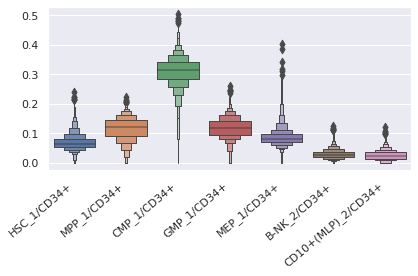

In [14]:
#Data from the first table, visualized
ax = sns.boxenplot(
    data=table1_relevant_pheno_df
)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.tight_layout()


### Data for the first figure: HSPCs out of PBMCs.
We'll compare regression for HSC/CD34+ to see if there is any relation even if Mantri et al. says tehre isn't.

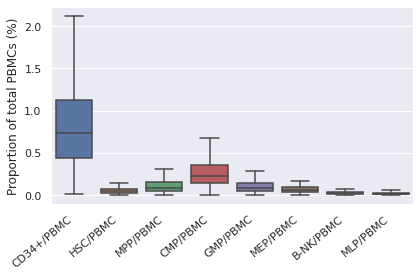

In [44]:
ax = sns.boxplot(data=fig1_df, showfliers = False)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
#ax.set(ylim=(None, 0.6))
ax.set_ylabel('Proportion of total PBMCs (%)')
plt.tight_layout()


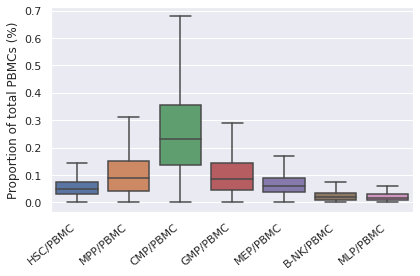

In [52]:
ax = sns.boxplot(data=fig1_df.drop('CD34+/PBMC', axis=1), showfliers = False)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
#ax.set(ylim=(None, 0.6))
ax.set_ylabel('Proportion of total PBMCs (%)')
plt.tight_layout()


In [62]:
#Plot and regression line
def scatter_and_regression(y_axis_pheno, fig_num):
    plt.figure(fig_num)
    plt.scatter(fig1_df['CD34+/PBMC'], fig1_df[y_axis_pheno])
    ax = sns.regplot(x=fig1_df['CD34+/PBMC'], y=fig1_df[y_axis_pheno],
                                 scatter=False,color='r',fit_reg=True, truncate=False)
    plt.show()

    slope, intercept, r_value, p_value, std_err = linregress(fig1_df['CD34+/PBMC'].astype(float).values, fig1_df[y_axis_pheno].astype(float).values)
    print('Linear Regression R-square: ',r_value**2)

Text(0, 0.5, 'HSC (percentage of PBMCs)')

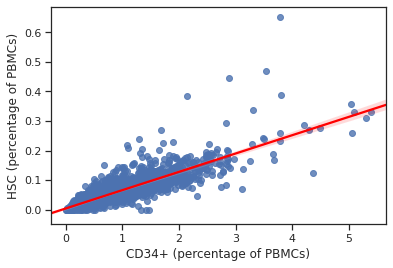

In [60]:
#Regression plot, HSC/CD34+ correlation
sns.set_style("ticks")

ax = sns.regplot(
    data=fig1_df,
    x="CD34+/PBMC", y="HSC/PBMC",
    scatter=True,
    fit_reg=True, truncate=False, line_kws={'color': 'red'})
ax.set_xlabel('CD34+ (percentage of PBMCs)')
ax.set_ylabel('HSC (percentage of PBMCs)')

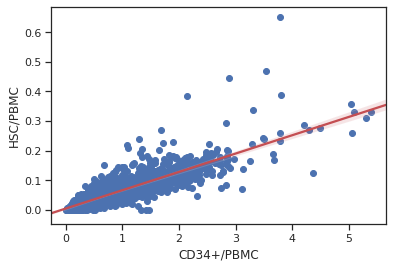

Linear Regression R-square:  0.7149388227646681


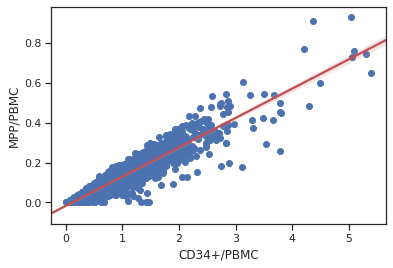

Linear Regression R-square:  0.8767567800500738


In [63]:
for index, pheno in enumerate(fig1_df.columns.tolist()[1:3]):
    scatter_and_regression(pheno, index)

In [19]:
#Spearman correlation
spearmanR, p_value = spearmanr(fig1_df['CD34+/PBMC'], fig1_df['HSC_1/PBMC'])
print('HSC')
print('Spearman correlation (r2): ', spearmanR**2)
print('P-value: ', p_value)

spearmanR, p_value = spearmanr(fig1_df['CD34+/PBMC'], fig1_df['MPP_1/PBMC'])
print('MPP')
print('Spearman correlation (r2): ', spearmanR**2)
print('P-value: ', p_value)

HSC
Spearman correlation (r2):  0.7582224865888106
P-value:  0.0
MPP
Spearman correlation (r2):  0.8730323311101866
P-value:  0.0


In [22]:
#Ordinary least squares

X = fig1_df['CD34+/PBMC']
X = sm.add_constant(X)
Y = fig1_df['HSC_1/PBMC']
model = sm.regression.linear_model.OLS(Y,X)
results = model.fit()

results.summary()


/home/antton/anaconda3/envs/python27env/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2580: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             HSC_1/PBMC   R-squared:                       0.769
Model:                            OLS   Adj. R-squared:                  0.769
Method:                 Least Squares   F-statistic:                     6192.
Date:                Thu, 08 Apr 2021   Prob (F-statistic):               0.00
Time:                        14:06:57   Log-Likelihood:                 4573.3
No. Observations:                1865   AIC:                            -9143.
Df Residuals:                    1863   BIC:                            -9131.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0033      0.001      3.852      0.000       0.002       0.005
CD34+/PBMC     0.0595      0.001     78.687      0.000       0.058       0.061
==============================================================================
Omnibus:                      751.306   Durbin-Watson:                   1.739
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            12134.115
Skew:                           1.455   Prob(JB):                         0.00
Kurtosis:                      15.152   Cond. No.                         3.34
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""